In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.optimizers import adam_v2
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2
from cv2 import imread, createCLAHE # read and equalize images

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from skimage.util import montage as montage2d

import os
from glob import glob
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!mkdir /home/datasets/TBX11K/Merged
!mkdir /home/datasets/TBX11K/Merged/train
!mkdir /home/datasets/TBX11K/Merged/validation

!mkdir /home/datasets/TBX11K/Merged/train/sick
!mkdir /home/datasets/TBX11K/Merged/train/health
!mkdir /home/datasets/TBX11K/Merged/train/tb

!mkdir /home/datasets/TBX11K/Merged/validation/sick
!mkdir /home/datasets/TBX11K/Merged/validation/health
!mkdir /home/datasets/TBX11K/Merged/validation/tb

In [3]:
TBX_TRAIN_DIR = '/home/datasets/TBX11K/train'
TBX_VAL_DIR = '/home/datasets/TBX11K/validation'

HEF_TRAIN_DIR = '/home/datasets/TBX11K/HEF/train'
HEF_VAL_DIR = '/home/datasets/TBX11K/HEF/validation'

BF_TRAIN_DIR = '/home/datasets/TBX11K/BF/train'
BF_VAL_DIR ='/home/datasets/TBX11K/BF/validation'

CLAHE_TRAIN_DIR = '/home/datasets/TBX11K/CLAHE/train'
CLAHE_VAL_DIR = '/home/datasets/TBX11K/CLAHE/validation'

MERGED_TRAIN_DIR = '/home/datasets/TBX11K/Merged/train'
MERGED_VAL_DIR = '/home/datasets/TBX11K/Merged/validation'

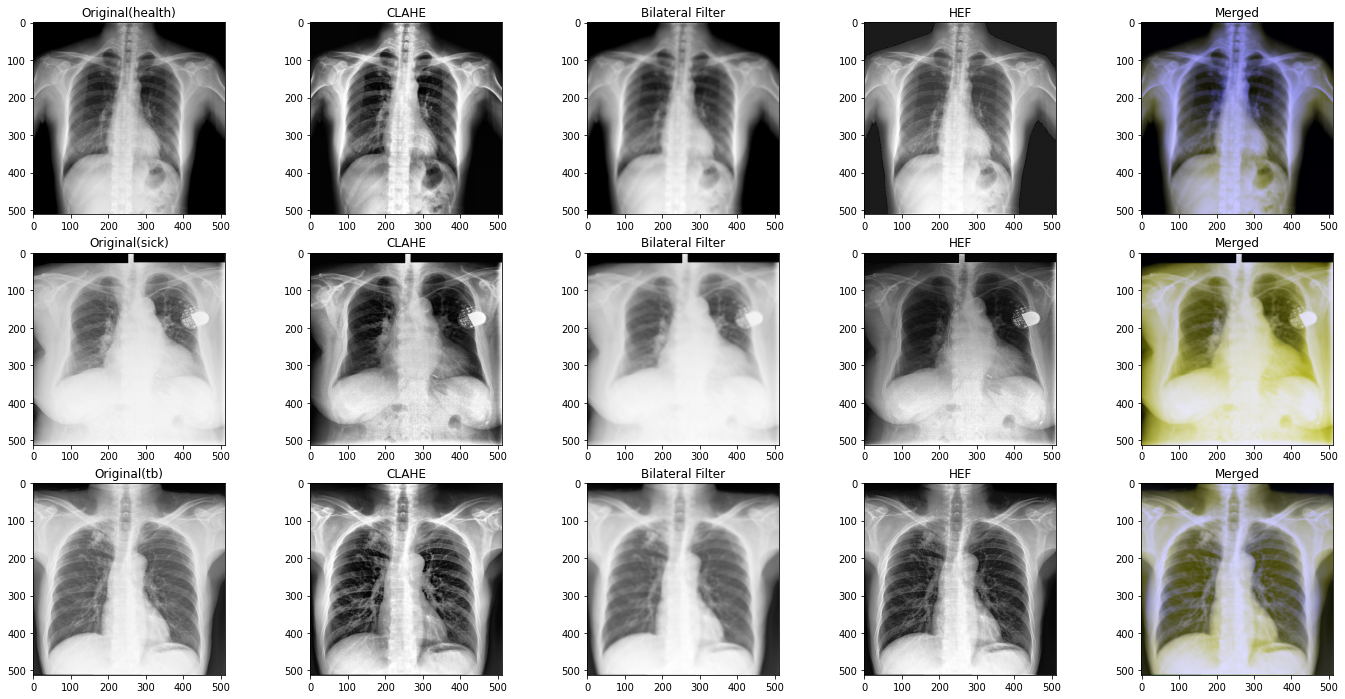

In [4]:
CLASSES = ['health','sick','tb']

fig, axs = plt.subplots(3, 5, figsize=(24, 12))

ctr = 0
for class_dir in CLASSES:
    img_files = glob(os.path.join(TBX_TRAIN_DIR,class_dir,'*.png'))
    
    original_file = img_files[120]
    basename = os.path.basename(original_file)
    
    hef_img_file = os.path.join(HEF_TRAIN_DIR,class_dir,basename)
    bf_img_file = os.path.join(BF_TRAIN_DIR,class_dir,basename)
    clahe_img_file = os.path.join(CLAHE_TRAIN_DIR,class_dir,basename)
    
    image = cv2.imread(original_file, cv2.IMREAD_GRAYSCALE)
    hef_img = cv2.imread(hef_img_file, cv2.IMREAD_GRAYSCALE)
    bf_img = cv2.imread(bf_img_file, cv2.IMREAD_GRAYSCALE)
    clahe_img = cv2.imread(clahe_img_file, cv2.IMREAD_GRAYSCALE)
    
    cv2.resize(image,(256,256))
    cv2.resize(hef_img,(256,256))
    cv2.resize(bf_img,(256,256))
    cv2.resize(clahe_img,(256,256))
    
    merged = cv2.merge([image,bf_img,clahe_img])
    
    
    axs[ctr, 0].set_title('Original('+class_dir+')')
    axs[ctr, 0].imshow(image,cmap='gray')
    
    axs[ctr, 1].set_title('CLAHE')
    axs[ctr, 1].imshow(clahe_img,cmap='gray')
    
    axs[ctr, 2].set_title('Bilateral Filter')
    axs[ctr, 2].imshow(bf_img,cmap='gray')
    
    axs[ctr, 3].set_title('HEF')
    axs[ctr, 3].imshow(hef_img,cmap='gray')   
    
    axs[ctr, 4].set_title('Merged')
    axs[ctr, 4].imshow(merged)  
    ctr += 1

plt.show()

#### Function for Merging Filter images 

In [5]:
def merge_train_image(src_file):
    
    basename = os.path.basename(src_file)
    
    hef_img_file = os.path.join(HEF_TRAIN_DIR,class_dir,basename)
    bf_img_file = os.path.join(BF_TRAIN_DIR,class_dir,basename)
    clahe_img_file = os.path.join(CLAHE_TRAIN_DIR,class_dir,basename)
    dst_file = os.path.join(MERGED_TRAIN_DIR,class_dir,basename)
    
    image = cv2.imread(src_file, cv2.IMREAD_GRAYSCALE)
    #hef_img = cv2.imread(hef_img_file, cv2.IMREAD_GRAYSCALE)
    bf_img = cv2.imread(bf_img_file, cv2.IMREAD_GRAYSCALE)
    clahe_img = cv2.imread(clahe_img_file, cv2.IMREAD_GRAYSCALE)
    
    cv2.resize(image,(256,256))
    #cv2.resize(hef_img,(256,256))
    cv2.resize(bf_img,(256,256))
    cv2.resize(clahe_img,(256,256))
    
    merged_image = cv2.merge([image,bf_img,clahe_img])
    
    cv2.imwrite(dst_file, merged_image)

def merge_val_image(src_file):
    basename = os.path.basename(src_file)
    
    #hef_img_file = os.path.join(HEF_VAL_DIR,class_dir,basename)
    bf_img_file = os.path.join(BF_VAL_DIR,class_dir,basename)
    clahe_img_file = os.path.join(CLAHE_VAL_DIR,class_dir,basename)
    dst_file = os.path.join(MERGED_VAL_DIR,class_dir,basename)
    
    image = cv2.imread(src_file, cv2.IMREAD_GRAYSCALE)
    #hef_img = cv2.imread(hef_img_file, cv2.IMREAD_GRAYSCALE)
    bf_img = cv2.imread(bf_img_file, cv2.IMREAD_GRAYSCALE)
    clahe_img = cv2.imread(clahe_img_file, cv2.IMREAD_GRAYSCALE)
    
    cv2.resize(image,(256,256))
    #cv2.resize(hef_img,(256,256))
    cv2.resize(bf_img,(256,256))
    cv2.resize(clahe_img,(256,256))
    
    merged_image = cv2.merge([image,bf_img,clahe_img])
    
    cv2.imwrite(dst_file, merged_image)

In [6]:
from multiprocessing import Pool
OUTPUT_SHAPE = (256,256)
for class_dir in tqdm(CLASSES):
    train_files = glob(os.path.join(TBX_TRAIN_DIR,class_dir,'*.png'))
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(merge_train_image, train_files)

100%|██████████| 3/3 [00:28<00:00,  9.38s/it]


In [7]:
from multiprocessing import Pool
OUTPUT_SHAPE = (256,256)
for class_dir in tqdm(CLASSES):
    train_files = glob(os.path.join(TBX_VAL_DIR,class_dir,'*.png'))
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(merge_val_image, train_files)

100%|██████████| 3/3 [00:08<00:00,  2.99s/it]
